In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Load the dataset from Kaggle
file_path = '/content/sample_data/SOL_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,open_time,open,high,low,close,volume
0,2023-07-10 15:00:00,21.17,21.19,21.13,21.14,11640.49
1,2023-07-10 15:01:00,21.14,21.17,21.11,21.11,5304.66
2,2023-07-10 15:02:00,21.12,21.12,21.09,21.11,4088.15
3,2023-07-10 15:03:00,21.11,21.14,21.10,21.14,7810.10
4,2023-07-10 15:04:00,21.15,21.17,21.11,21.11,2510.23


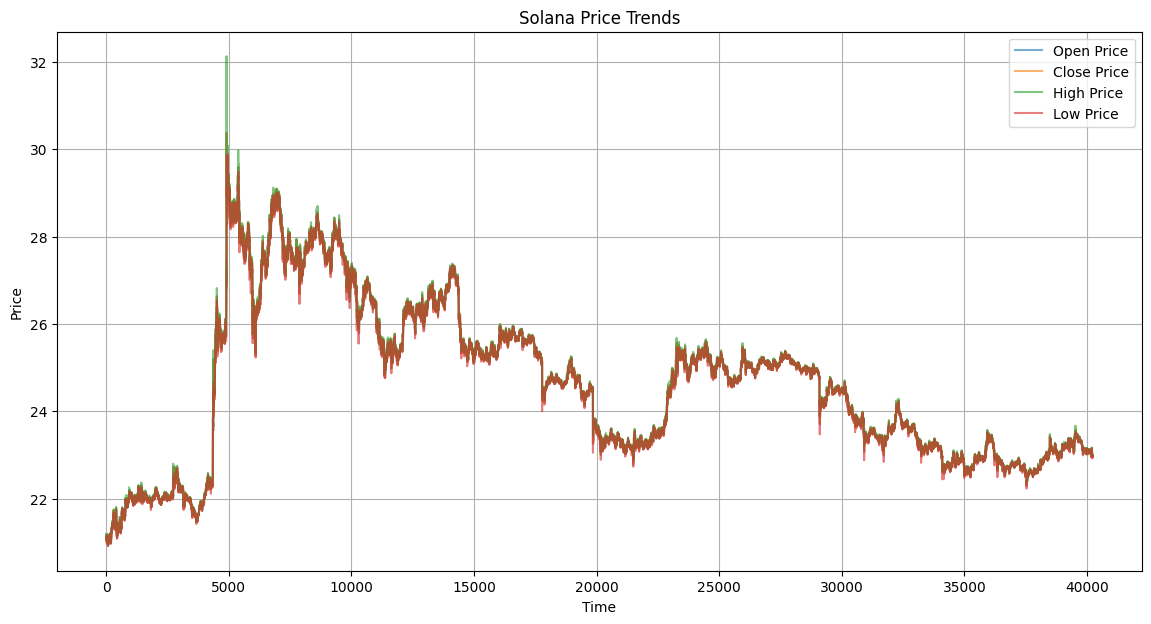

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['open'], label='Open Price', alpha=0.6)
plt.plot(data.index, data['close'], label='Close Price', alpha=0.6)
plt.plot(data.index, data['high'], label='High Price', alpha=0.6)
plt.plot(data.index, data['low'], label='Low Price', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Solana Price Trends')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# TensorFlow가 GPU를 인식하는지 확인
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPU details: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  0
GPU details:  []


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 텐서플로가 첫 번째 GPU만 사용하도록 제한
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU 설정 완료")
    except RuntimeError as e:
        # 메모리 증가가 설정된 후에는 장치를 수정할 수 없습니다
        print(e)

In [ ]:
#RSI 10 20 60  계산

def calculate_rsi(data, window):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

data['RSI_10'] = calculate_rsi(data['close'], 10)
data['RSI_20'] = calculate_rsi(data['close'], 20)
data['RSI_60'] = calculate_rsi(data['close'], 60)

In [ ]:
#MACD(12,26,9)

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate the short term exponential moving average (EMA)
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    # Calculate the long term exponential moving average (EMA)
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    # Calculate the MACD line
    macd_line = short_ema - long_ema
    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

# Calculate MACD values
data['MACD_Line'], data['Signal_Line'], data['MACD_Histogram'] = calculate_macd(data['close'])

In [ ]:
#CCI 5 10 20

def calculate_cci(data, window):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma = tp.rolling(window=window).mean()
    mad = (tp - sma).abs().rolling(window=window).mean()
    cci = (tp - sma) / (0.015 * mad)

    return cci

# Calculate CCI for different windows
data['CCI_5'] = calculate_cci(data, 5)
data['CCI_10'] = calculate_cci(data, 10)
data['CCI_20'] = calculate_cci(data, 20)

In [ ]:
#RSI STOCHASTIC 10 20 60

def calculate_rsi_stochastics(data, rsi_window, k_window, d_window):
    rsi = calculate_rsi(data['close'], rsi_window)
    lowest_rsi = rsi.rolling(window=k_window).min()
    highest_rsi = rsi.rolling(window=k_window).max()

    rsi_stochastic_k = 100 * ((rsi - lowest_rsi) / (highest_rsi - lowest_rsi))
    rsi_stochastic_d = rsi_stochastic_k.rolling(window=d_window).mean()

    return rsi_stochastic_k, rsi_stochastic_d

# Calculate RSI-Stochastics for different RSI windows
data['RSI_Stoch_K_10'], data['RSI_Stoch_D_10'] = calculate_rsi_stochastics(data, 10, 3, 3)
data['RSI_Stoch_K_20'], data['RSI_Stoch_D_20'] = calculate_rsi_stochastics(data, 20, 3, 3)
data['RSI_Stoch_K_60'], data['RSI_Stoch_D_60'] = calculate_rsi_stochastics(data, 60, 3, 3)

In [ ]:
#MFI 10 20 60

def calculate_mfi(data, window):
    typical_price = (data['high'] + data['low'] + data['close']) / 3
    money_flow = typical_price * data['volume']

    positive_flow = money_flow.copy()
    negative_flow = money_flow.copy()

    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            negative_flow[i] = 0
        else:
            positive_flow[i] = 0

    positive_mf = positive_flow.rolling(window=window).sum()
    negative_mf = negative_flow.rolling(window=window).sum()

    mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))

    return mfi

# Calculate MFI for different windows
data['MFI_10'] = calculate_mfi(data, 10)
data['MFI_20'] = calculate_mfi(data, 20)
data['MFI_60'] = calculate_mfi(data, 60)

In [ ]:
#VR 10 20 60

def calculate_volume_ratio(data, window):
    volume_ratio = data['volume'] / data['volume'].rolling(window=window).mean()
    return volume_ratio

# Calculate Volume Ratio for different windows
data['Volume_Ratio_10'] = calculate_volume_ratio(data, 10)
data['Volume_Ratio_20'] = calculate_volume_ratio(data, 20)
data['Volume_Ratio_60'] = calculate_volume_ratio(data, 60)

In [ ]:
#Bollinger Band 10 20 60

def calculate_bollinger_bands(data, window):
    rolling_mean = data['close'].rolling(window=window).mean()
    rolling_std = data['close'].rolling(window=window).std()

    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)

    return rolling_mean, upper_band, lower_band

# Calculate Bollinger Bands for different windows
data['BB_Mean_10'], data['BB_Upper_10'], data['BB_Lower_10'] = calculate_bollinger_bands(data, 10)
data['BB_Mean_20'], data['BB_Upper_20'], data['BB_Lower_20'] = calculate_bollinger_bands(data, 20)
data['BB_Mean_60'], data['BB_Upper_60'], data['BB_Lower_60'] = calculate_bollinger_bands(data, 60)

In [ ]:
#Ichimoku Cloud (9 26 52)

def calculate_ichimoku(data, short_window, medium_window, long_window):
    # Calculate Tenkan-Sen (Conversion Line)
    high_short = data['high'].rolling(window=short_window).max()
    low_short = data['low'].rolling(window=short_window).min()
    data['Tenkan_Sen'] = (high_short + low_short) / 2

    # Calculate Kijun-Sen (Base Line)
    high_medium = data['high'].rolling(window=medium_window).max()
    low_medium = data['low'].rolling(window=medium_window).min()
    data['Kijun_Sen'] = (high_medium + low_medium) / 2

    # Calculate Senkou Span A (Leading Span A)
    data['Senkou_Span_A'] = ((data['Tenkan_Sen'] + data['Kijun_Sen']) / 2).shift(medium_window)

    # Calculate Senkou Span B (Leading Span B)
    high_long = data['high'].rolling(window=long_window).max()
    low_long = data['low'].rolling(window=long_window).min()
    data['Senkou_Span_B'] = ((high_long + low_long) / 2).shift(medium_window)

    # Calculate Chikou Span (Lagging Span)
    data['Chikou_Span'] = data['close'].shift(-medium_window)

    return data

# Calculate Ichimoku Cloud components
data = calculate_ichimoku(data, 9, 26, 52)

In [ ]:
#Envelope 10 20 60

def calculate_envelope(data, window, percentage=0.025):
    moving_average = data['close'].rolling(window=window).mean()
    upper_band = moving_average * (1 + percentage)
    lower_band = moving_average * (1 - percentage)

    return moving_average, upper_band, lower_band

# Calculate Envelope for different windows
data['Envelope_MA_10'], data['Envelope_Upper_10'], data['Envelope_Lower_10'] = calculate_envelope(data, 10)
data['Envelope_MA_20'], data['Envelope_Upper_20'], data['Envelope_Lower_20'] = calculate_envelope(data, 20)
data['Envelope_MA_60'], data['Envelope_Upper_60'], data['Envelope_Lower_60'] = calculate_envelope(data, 60)

In [ ]:
def calculate_fibo_retracement(data, fibo_length, indicator_length, source, indicator_type):
    # Ensure volume column is present if necessary
    if 'volume' not in data.columns:
        raise ValueError("Volume data is required for certain indicators but not provided.")

    # Function to calculate the chosen indicator
    def get_indicator(data, length, indicator_type):
        if indicator_type == 'RSI':
            delta = data[source].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
            rs = gain / loss
            return 100 - (100 / (1 + rs))
        elif indicator_type == 'CCI':
            tp = (data['high'] + data['low'] + data[source]) / 3
            return (tp - tp.rolling(window=length).mean()) / (0.015 * tp.rolling(window=length).std())
        elif indicator_type == 'MFI':
            tp = (data['high'] + data['low'] + data[source]) / 3
            mf = tp * data['volume']
            positive_mf = mf.where(data[source].diff() > 0, 0)
            negative_mf = mf.where(data[source].diff() < 0, 0)
            mfi = 100 - (100 / (1 + (positive_mf.rolling(window=length).sum() / negative_mf.rolling(window=length).sum())))
            return mfi
        elif indicator_type == 'STOCHASTIC':
            lowest_low = data['low'].rolling(window=length).min()
            highest_high = data['high'].rolling(window=length).max()
            return 100 * (data[source] - lowest_low) / (highest_high - lowest_high)
        elif indicator_type == 'CMF':
            mfv = ((2 * data['close'] - data['low'] - data['high']) / (data['high'] - data['low'])) * data['volume']
            return mfv.rolling(window=length).sum() / data['volume'].rolling(window=length).sum()
        elif indicator_type == 'CMO':
            diff = data[source].diff()
            return 100 * (diff.rolling(window=length).apply(lambda x: np.sum(x[x > 0]) - np.sum(x[x < 0])) /
                          diff.rolling(window=length).apply(lambda x: np.sum(np.abs(x))))
        else:
            raise ValueError(f"Unknown indicator type: {indicator_type}")

    # Calculate the chosen indicator
    data['INDICATOR'] = get_indicator(data, indicator_length, indicator_type)

    # Calculate highest and lowest points
    data['high_ind'] = data['INDICATOR'].rolling(window=fibo_length).max()
    data['low_ind'] = data['INDICATOR'].rolling(window=fibo_length).min()

    # Calculate the Fibonacci retracement levels
    data['diff'] = data['high_ind'] - data['low_ind']

    return data

# Apply the function to the data
result = calculate_fibo_retracement(data, 60, 10, 'close', 'RSI')

In [ ]:
# 저장할 경로 설정
save_path0 = '/content/Output/SOL60_Indicator.csv'

# CSV 파일로 저장
data.to_csv(save_path0, index=False)